<a href="https://colab.research.google.com/github/adimyth/legal_language_model/blob/master/notebooks/LanguageModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning the repo

In [0]:
!git clone https://github.com/adimyth/legal_language_model.git

Cloning into 'legal_language_model'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [0]:
%cd legal_language_model/

/content/legal_language_model


## Imports

In [0]:
import pandas as pd
from fastai.text import *
from pathlib import Path
from tqdm import tqdm

In [0]:
base_path = Path('.')
path = base_path/'judgements.csv'
BATCH_SIZE = 64

## Sanity

In [0]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Configurations

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
%%writefile .env
user=justiceleague
password=justiceleagueadmin
dbname=justiceleaguedb
host=justiceleaguedb.cjlmdpabvwhv.ap-south-1.rds.amazonaws.com
port=5432

Writing .env


## Downloading Legal Data

In [0]:
!pip install python-dotenv

In [0]:
!python extractor.py

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [0]:
df = pd.read_csv(path, encoding='latin-1')

In [0]:
df.head()

,text
0,http://JUDIS.NIC.IN SUPREME COURT OF INDIA Pag...
1,http://JUDIS.NIC.IN SUPREME COURT OF INDIA Pag...
2,http://JUDIS.NIC.IN SUPREME COURT OF INDIA Pag...
3,http://JUDIS.NIC.IN SUPREME COURT OF INDIA Pag...
4,http://JUDIS.NIC.IN SUPREME COURT OF INDIA Pag...


## Extracting only judgements

In [0]:
df['text'] = df['text'].str.partition('JUDGMENT')[2]

In [0]:
len([text for text in df['text'].tolist() if text == ''])

352

In [0]:
df.shape

(10000, 1)

In [0]:
df = df.query('text != ""')

In [0]:
df.shape

(9648, 1)

In [0]:
df['text'].head()

0    :\n21/12/1950\n\nBENCH:\nKANIA, HIRALAL J. (CJ...
1    :\n21/12/1950\n\nBENCH:\nKANIA, HIRALAL J. (CJ...
2    :\n21/12/1950\n\nBENCH:\nKANIA, HIRALAL J. (CJ...
3    :\n21/12/1950\n\nBENCH:\nFAZAL ALI, SAIYID\nBE...
4    :\n20/12/1950\n\nBENCH:\nFAZAL ALI, SAIYID\nBE...
Name: text, dtype: object

In [0]:
df['label'] = [0]*df.shape[0]

In [0]:
df.to_csv(base_path/'intermediate.csv', index=False)

## Saving each judgement as a text file

In [0]:
!mkdir data

In [0]:
for idx, row in tqdm(df['text'].iteritems()):
    file_title = base_path/f'data/{idx}.txt'
    with open(file_title, 'w') as file:
      file.write(row)

9648it [00:01, 6008.69it/s]


## Text Language Model

In [0]:
!ls

conda.yml  data_lm.pkl	 intermediate.csv  legal_language_model  notebooks
data	   extractor.py  judgements.csv    models		 README.md


In [0]:
trn_texts = df.loc[0:8000, 'text'].values
trn_labels = df.loc[0:8000, 'label'].values
val_texts = df.loc[8000:10000, 'text'].values
val_labels = df.loc[8000:10000, 'label'].values
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]
trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)


In [0]:
data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)

In [19]:
data_lm.show_batch()

idx,text
0,"info : \n xxup rf 1992 xxup xxunk ( 5 ) \n \n xxup act : \n xxmaj arbitration xxmaj act ( 10 of 1940 ) , xxmaj sch . 1 , para . 4 - -appointment \n of umpire by arbitrators - xxmaj whether consent of umpire \n necessary - xxmaj disagreement between arbitrators what is . \n \n xxup headnote : \n"
1,"binding material not exceeding 0.625 xxmaj kilograms per \n quintal of sugarcane ; and , \n x x x \n xxmaj clause 4 conferred power on the xxmaj central xxmaj government or a \n xxmaj state xxmaj government with the concurrence of the xxmaj central \n xxmaj government to fix the minimum price or the price of \n sugarcane to be paid by producers"
2,"correlation between the amount \n paid by way of cess under the xxmaj act and the services rendered \n to the person from whom it is collected . xxmaj the impost in these \n cases lacks the essential qualification of a fee namely \n âthat it is absolutely necessary that the levy of fees \n should on the face of the legislative provision , be"
3,"law must have universal application for all \n 351 \n persons who are not by nature , attainment or circumstances \n in the same position , and the varying needs of different \n classes of persons often require separate treatment . \n 4 . xxmaj the principle does not take away from the xxmaj state \n the power of classifying persons for legitimate purposes"
4,"for xxup ms - xxup hsd . xxmaj the \n applicant has stated that he is a \n graduate from xxmaj xxunk and xxmaj kashmir , \n who has been forced to migrate from \n xxmaj kashmir as result of militant \n threats to his life . xxmaj the applicant \n has also state that he has no \n regular source of income"


In [0]:
# data_lm = (TextList.from_folder(base_path/'data')
#          .split_by_rand_pct(0.1)
#            .label_for_lm()
#            .databunch(bs=BATCH_SIZE))

In [0]:
data_lm.save('data_lm.pkl')

In [23]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '\n ',
 'the',
 'of',
 ',',
 '.',
 'to',
 'in',
 'and',
 'that',
 'a',
 'is']

In [0]:
data_lm = load_data(base_path, 'data_lm.pkl', bs=BATCH_SIZE)

In [42]:
data_lm.show_batch()

idx,text
0,"info : \n xxup rf 1992 xxup xxunk ( 5 ) \n \n xxup act : \n xxmaj arbitration xxmaj act ( 10 of 1940 ) , xxmaj sch . 1 , para . 4 - -appointment \n of umpire by arbitrators - xxmaj whether consent of umpire \n necessary - xxmaj disagreement between arbitrators what is . \n \n xxup headnote : \n"
1,"binding material not exceeding 0.625 xxmaj kilograms per \n quintal of sugarcane ; and , \n x x x \n xxmaj clause 4 conferred power on the xxmaj central xxmaj government or a \n xxmaj state xxmaj government with the concurrence of the xxmaj central \n xxmaj government to fix the minimum price or the price of \n sugarcane to be paid by producers"
2,"correlation between the amount \n paid by way of cess under the xxmaj act and the services rendered \n to the person from whom it is collected . xxmaj the impost in these \n cases lacks the essential qualification of a fee namely \n âthat it is absolutely necessary that the levy of fees \n should on the face of the legislative provision , be"
3,"law must have universal application for all \n 351 \n persons who are not by nature , attainment or circumstances \n in the same position , and the varying needs of different \n classes of persons often require separate treatment . \n 4 . xxmaj the principle does not take away from the xxmaj state \n the power of classifying persons for legitimate purposes"
4,"for xxup ms - xxup hsd . xxmaj the \n applicant has stated that he is a \n graduate from xxmaj xxunk and xxmaj kashmir , \n who has been forced to migrate from \n xxmaj kashmir as result of militant \n threats to his life . xxmaj the applicant \n has also state that he has no \n regular source of income"


## Saving pkl to drive

In [25]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'Trained Data'})
uploaded.SetContentFile('data_lm.pkl')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# Download to google drive
drive.CreateFile({'id': uploaded.get('id')})

    100% |████████████████████████████████| 993kB 22.9MB/s 
Uploaded file with ID 15vAPNCabqQ9dy_KeVdANQ-OarLzJ0I5x


GoogleDriveFile({'id': '15vAPNCabqQ9dy_KeVdANQ-OarLzJ0I5x'})

## Language Model Learner

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


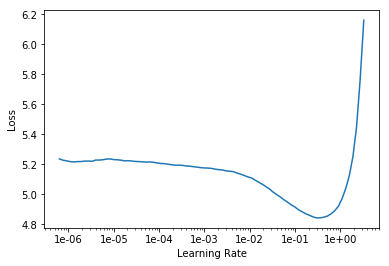

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.530059,3.533904,0.367892,1:42:22


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.743639,0.727928,0.819190,01:05
1,0.734148,0.724386,0.820256,01:04
2,0.714891,0.718798,0.819083,01:05
3,0.697528,0.709952,0.820362,01:04
4,0.684154,0.702734,0.822175,01:04
5,0.676741,0.703850,0.822601,01:04
6,0.661864,0.704042,0.822495,01:04
7,0.666319,0.702129,0.820895,01:05
8,0.643020,0.701977,0.821428,01:04
9,0.646635,0.702175,0.821429,01:04


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Under the act"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Under the act ] xxbos [ 2 39 9 389 ... 5 74 253 13 ] xxbos [ 2 39 9 259 ... 295 13 9 893 ] xxbos [ 2 39 9 340 ... 253 13 9 441 ] xxbos [ 2
Under the act ] xxbos [ 2 39 9 354 ... 253 13 9 2387 ] xxbos [ 2 39 9 208 ... 5 74 253 13 ] xxbos [ 2 39 9 571 ... 5 74 253 13 ] xxbos [ 2


In [0]:
!gpustat

8f2b58800e8d  Wed Apr 17 11:27:15 2019
[0] Tesla T4         | 72'C,   0 % | 12905 / 15079 MB |
